# Libraries

In [1]:
import numpy as np
import random
from sklearn.datasets import fetch_20newsgroups #news group data set
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC

# Question 1

Plot a histogram of the number of training documents for each of the 20 categories to check if they are evenly distributed.

In [2]:
newsgroups_train = fetch_20newsgroups(subset='train')

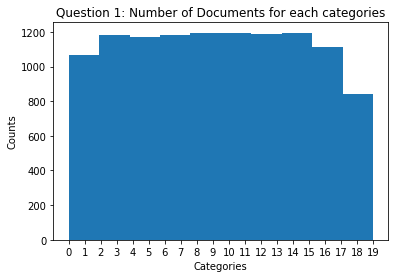

In [3]:
type(newsgroups_train.target)
news_target = newsgroups_train.target
plt.hist(news_target)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.xticks(list(range(20)))
plt.title('Question 1: Number of Documents for each categories')
plt.show()

# Question 2

Use the following specs to extract features from the textual data:
• Use the “english” stopwords of the CountVectorizer
• Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)
• Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos_tag
• Use min_df=3
Report the shape of the TF-IDF matrices of the train and test subsets respectively.

In [5]:
np.random.seed(42);
random.seed(42); # do I set the random here
categories = ['comp.graphics', 
              'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware', 
              'comp.sys.mac.hardware', 
              'rec.autos', 
              'rec.motorcycles', 
              'rec.sport.baseball', 
              'rec.sport.hockey']

train_dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=None)
test_dataset = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=None)

In [6]:
# Customize analyzer
analyzer = CountVectorizer().build_analyzer();
# Lemmatizer
wnl = nltk.wordnet.WordNetLemmatizer()

def lemmatize_sent(list_word):
    return [wnl.lemmatize(word.lower()) for word, tag, in pos_tag(list_word)]

def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if not word.isdigit())

count_vect = CountVectorizer(stop_words='english', min_df=3, analyzer=stem_rmv_punc)

### Training Part

In [7]:
tfidf_transformer = TfidfTransformer()
X_train_counts = count_vect.fit_transform(train_dataset.data)
X_train_tf_idf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tf_idf.shape

(4732, 17602)

### Testing Part

In [9]:
X_test_counts = count_vect.fit_transform(test_dataset.data)
X_test_tf_idf = tfidf_transformer.fit_transform(X_test_counts)
X_test_tf_idf.shape

(3150, 12399)

# Question 3

Reduce the dimensionality of the data using the methods above

• Apply LSI to the TF-IDF matrix corresponding to the 8 categories with k = 50; so each document is mapped to a 50-dimensional vector.

• Also reduce dimensionality through NMF (k = 50) and compare with LSI:
Which one is larger, the ∥X − WH∥ F 2 in NMF or the X − U k Σ k V T k F in LSI? Why is the case?

In [15]:
# NMF
## Train
model_train = NMF(n_components=50, init='random', random_state=0)
NMF_train_reduced = model_train.fit_transform(X_train_tf_idf)
## Test
model_test = NMF(n_components=50, init='random', random_state=0)
NMF_test_reduced = model_test.fit_transform(X_test_tf_idf)

In [17]:
H_train = model_train.components_
H_test = model_test.components_
NMF_train_val = np.sum(np.array(X_train_tf_idf - NMF_train_reduced.dot(H_train))**2)
NMF_test_val = np.sum(np.array(X_test_tf_idf - NMF_test_reduced.dot(H_test))**2)

In [18]:
print("||X-WH||^2_F Train: ", NMF_train_val)
print("||X-WH||^2_F Test: ", NMF_test_val)

||X-WH||^2_F Train:  3975.5593809415495
||X-WH||^2_F Test:  2588.077054957411


In [20]:
# LSI
## Train
svd_train = TruncatedSVD(n_components=50, random_state=0)
LSI_train_reduced = svd_train.fit_transform(X_train_tf_idf)
## Test
svd_test = TruncatedSVD(n_components=50, random_state=0)
LSI_test_reduced = svd_test.fit_transform(X_test_tf_idf)

In [21]:
H_train = svd_train.components_
H_test = svd_test.components_
## Train
LSI_train_val = np.sum(np.array(X_train_tf_idf - LSI_train_reduced.dot(H_train))**2)
## Test
LSI_test_val = np.sum(np.array(X_test_tf_idf - LSI_test_reduced.dot(H_test))**2)

In [22]:
print("||X - USigmaV^T||^2_F Train", LSI_train_val)
print("||X - USigmaV^T||^2_F Test", LSI_test_val)

||X - USigmaV^T||^2_F Train 3931.944773503225
||X - USigmaV^T||^2_F Test 2553.5130603589096


# Question 4

In [27]:
svc_model = LinearSVC().fit(NMF_train_reduced, train_dataset.target)
pred_res = svc_model.predict(NMF_test_reduced)
pre

array([3, 7, 2, ..., 0, 1, 6])

In [36]:
right_cnt = 0
for i in range(len(pred_res)):
    if pred_res[i] == test_dataset.target[i]:
        right_cnt += 1
acura = right_cnt * 1.0 / len(pred_res)
acura

0.14761904761904762

In [33]:
len(pred_res)

3150